### Entrainement de modéles

##### 1. Récupérer les embeddings depuis ChromaDB

In [25]:
def get_collection(client, name):
    train_collection = client.get_collection(name=f'train_collection_{name}')
    test_collection = client.get_collection(name=f'test_collection_{name}')

    print(f'Train - {name.capitalize() :15s} ->     ', train_collection.count())
    print(f'Test  - {name.capitalize() :15s} ->     ', test_collection.count())
    print('')

    return [train_collection, test_collection]


In [26]:
import chromadb

client = chromadb.PersistentClient(path='../data/chroma_db')

train_collection_clean, test_collection_clean = get_collection(client, 'clean')

train_collection_mentions, test_collection_mentions = get_collection(client, 'mentions')

train_collection_undersampling, test_collection_undersampling = get_collection(client, 'undersampling')

Train - Clean           ->      12410
Test  - Clean           ->      2191

Train - Mentions        ->      12410
Test  - Mentions        ->      2191

Train - Undersampling   ->      7254
Test  - Undersampling   ->      1281



##### 2. Extraction de labels et d'embeddings

In [27]:
import numpy as np

def extract_train_test_dataframes(train_collection, test_collection):
    train_metadatas = train_collection.get(include=["metadatas", "embeddings"])
    test_metadatas = test_collection.get(include=["metadatas", "embeddings"])

    train_labels = [metadata['label'] for metadata in train_metadatas['metadatas']]
    test_labels = [metadata['label'] for metadata in test_metadatas['metadatas']]

    train_embeddings = [emb for emb in train_metadatas['embeddings']]
    test_embeddings = [emb for emb in test_metadatas['embeddings']]

    X_train = np.array(train_embeddings)
    y_train = np.array(train_labels)
    X_test = np.array(test_embeddings)
    y_test = np.array(test_labels)

    print('X_Train ->', len(X_train))
    print('Y_Train ->', len(y_train))
    print('X_Test  ->', len(X_test))
    print('Y_Test  ->', len(y_test))

    return [X_train, y_train, X_test, y_test]

- Data 1: data_clean

In [28]:
clean_sets = \
extract_train_test_dataframes(train_collection_clean, test_collection_clean)

X_Train -> 12410
Y_Train -> 12410
X_Test  -> 2191
Y_Test  -> 2191


- Data 2: data_with_mentions

In [29]:
mentions_sets = \
extract_train_test_dataframes(train_collection_mentions, test_collection_mentions)

X_Train -> 12410
Y_Train -> 12410
X_Test  -> 2191
Y_Test  -> 2191


- Data 3: data_balanced_undersampling

In [30]:
undersampling_sets = \
extract_train_test_dataframes(train_collection_undersampling, test_collection_undersampling)

X_Train -> 7254
Y_Train -> 7254
X_Test  -> 1281
Y_Test  -> 1281


##### 3. Créer des fonctions d'entraînement de différents modèles ML sur les embeddings.

In [31]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import time


- Fonction pour entrainer un modèle

In [32]:
def train_model(model, X_train, y_train, X_test, y_test, name, models, avg):

    print(f"--- Entrainemnt du modèle --------> {name}", '\n')

    #
    before = time.time()

    # Entrainer
    model.fit(X_train, y_train)

    # 
    after = time.time()

    # Prédire
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred, average=avg)
    rc = recall_score(y_test, y_pred, average=avg)
    f1 = f1_score(y_test, y_pred, average=avg)
    train_time = round(after - before)

    # Gap enter train vs test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    gap = train_acc - test_acc

    # Affichage
    print("Accuracy --> ", acc, '\n')

    print("Train accuracy:", train_acc)
    print("Test accuracy:", test_acc)
    print("Generalization gap:", gap, '\n')

    print(f"Train Time: {train_time}s\n")
    
    print("Rapport de classification:\n")
    print(classification_report(y_test, y_pred))

    print('-----------------------------------------------\n\n')

    models[name] = model

    return [name, acc, pr, rc, f1, gap, train_time]

- Fonction pour évaluer un modèle

In [33]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, X_train, y_train, X_test, y_test, name):

    if (name in ['XGBoost']):
        return
        
    plt.figure(figsize=(15, 7))

    #### 1st Plot

    plt.subplot(1, 2, 1)

    train_sizes, train_scores, test_scores = learning_curve(
        model, 
        X_train, y_train, 
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy',
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Train Accuracy')
    plt.plot(train_sizes, test_mean, label='Test Accuracy')
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend()

    ### 2nd Plot

    if (name in ["Linear SVC"]):
        plt.show()
        return

    classes = np.unique(y_train)
    n_classes = len(classes)

    # Binarize train and test labels
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin  = label_binarize(y_test, classes=classes)

    # Get predicted probabilities
    y_train_scores = model.predict_proba(X_train)
    y_test_scores  = model.predict_proba(X_test)

    plt.subplot(1, 2, 2)
    
    for i in range(n_classes):
        # ROC for train
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
        auc_train = auc(fpr_train, tpr_train)
        plt.plot(fpr_train, tpr_train, color='red', linestyle='-', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
        
        # ROC for test
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
        auc_test = auc(fpr_test, tpr_test)
        plt.plot(fpr_test, tpr_test, color="green", linestyle='-', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train vs Test ROC — Multiclass (One-vs-Rest)")
    plt.legend()
    plt.grid(True)
    plt.show()

- Fonction pour entrainer et évaluer plusieurs modéles

In [34]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, name, models, avg):

    # Entrainer le modéle

    scores = train_model(
        model,
        X_train, y_train, X_test, y_test,
        name,
        models,
        avg
    )

    # Evaluer un modéle

    evaluate_model(
        model,
        X_train, y_train, X_test, y_test,
        name
    )

    return scores

- Fonction pour entrainer plusieurs modèles

In [35]:
def train_multiple_models(X_train, y_train, X_test, y_test, balanced = None, avg = "weighted"):

    models = {}
    scores = []

    # Logistic Regression

    sc1 = train_evaluate_model(
        LogisticRegression(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Logistic Regression",
        models,
        avg
    )

    # Random Forest
   
    sc2 = train_evaluate_model(
        RandomForestClassifier(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Random Forest",
        models,
        avg
    )

    # Linear SVC
   
    sc3 = train_evaluate_model(
        LinearSVC(class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "Linear SVC",
        models,
        avg
    )

    # XGBoost
   
    sc4 = train_evaluate_model(
        XGBClassifier(),
        X_train, y_train, X_test, y_test,
        "XGBoost",
        models,
        avg
    )

    # SVC
   
    sc5 = train_evaluate_model(
        SVC(probability=True, class_weight=balanced),
        X_train, y_train, X_test, y_test,
        "SVC",
        models,
        avg
    )

    # KNN

    sc6 = train_evaluate_model(
        KNeighborsClassifier(),
        X_train, y_train, X_test, y_test,
        "KNN",
        models,
        avg
    )

    for score in [sc1, sc2, sc3, sc4, sc5, sc6]:
        scores.append(score)

    scores_df = pd.DataFrame(scores, columns=["Name", "Accuracy", "Precision", "Recall", "F1", "Train_Test Gap", "Train Time (s)"])
        
    return [scores_df, models]

##### 4. Entraîner et évaluer les modèles de machine learning sur des données différentes.

##### 4.1. Data 1: data_clean

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8512094933820173 

Train accuracy: 0.863013698630137
Test accuracy: 0.8512094933820173
Generalization gap: 0.011804205248119648 

Train Time: 3s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1374
           1       0.73      0.70      0.71       464
           2       0.84      0.72      0.78       353

    accuracy                           0.85      2191
   macro avg       0.82      0.79      0.80      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------




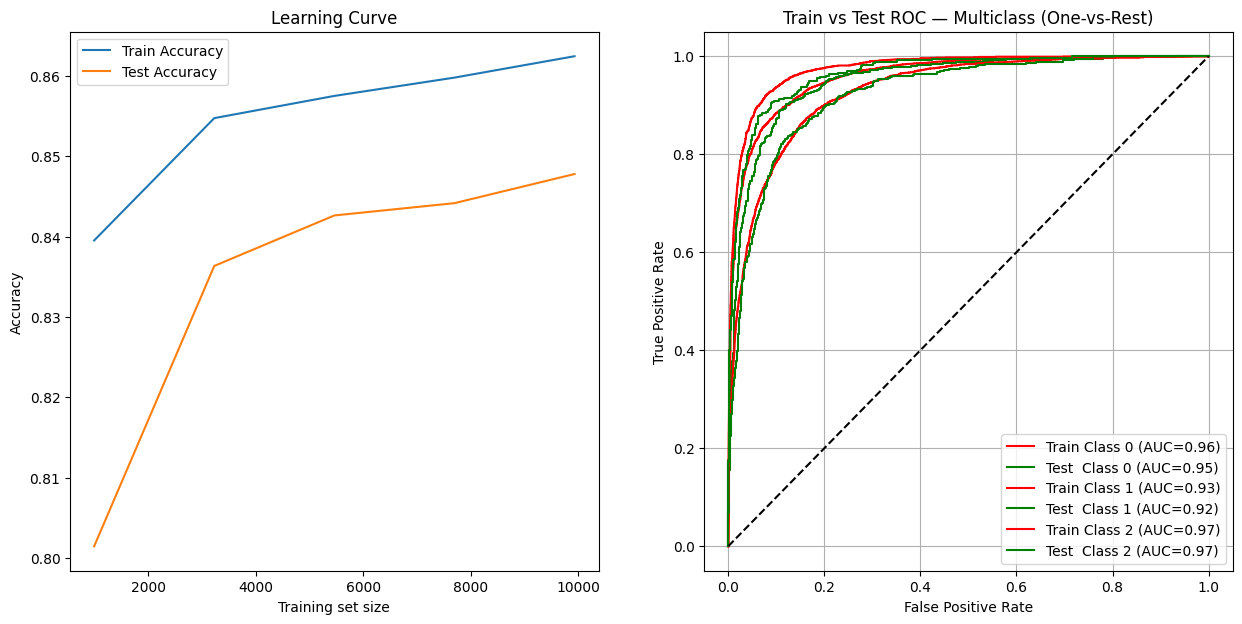

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7850296668188042 

Train accuracy: 0.9979049153908138
Test accuracy: 0.7850296668188042
Generalization gap: 0.21287524857200968 

Train Time: 88s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1374
           1       0.73      0.39      0.51       464
           2       0.86      0.54      0.67       353

    accuracy                           0.79      2191
   macro avg       0.79      0.64      0.68      2191
weighted avg       0.78      0.79      0.76      2191

-----------------------------------------------




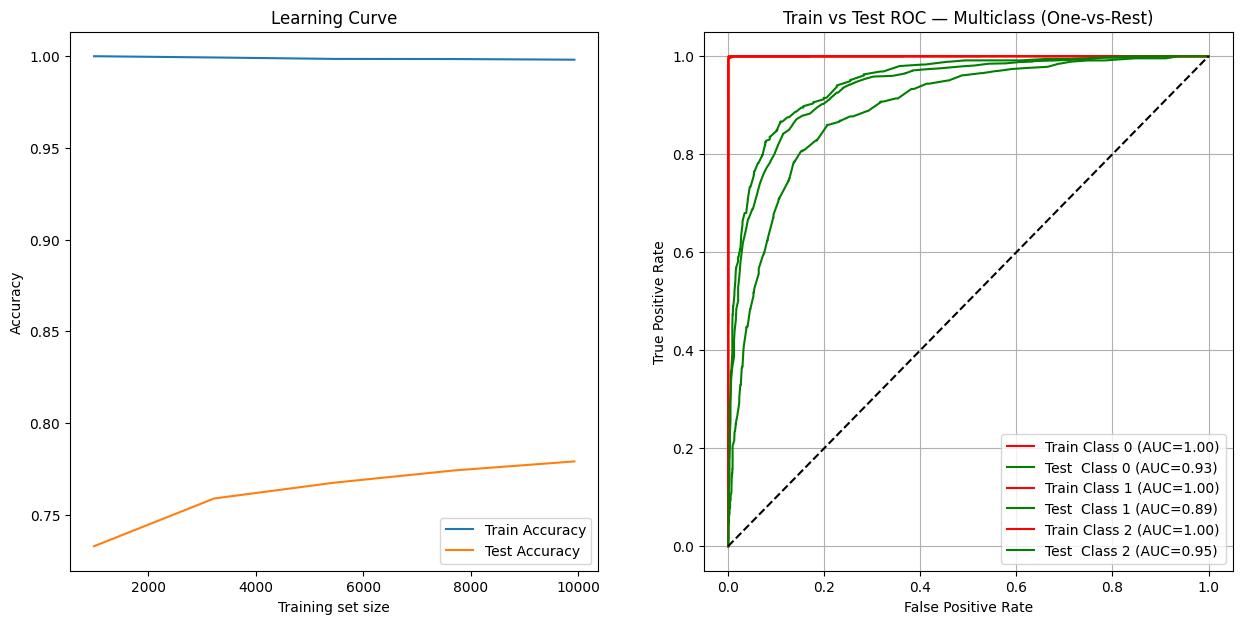

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.848927430397079 

Train accuracy: 0.8748589846897663
Test accuracy: 0.848927430397079
Generalization gap: 0.025931554292687342 

Train Time: 7s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1374
           1       0.73      0.70      0.71       464
           2       0.81      0.75      0.78       353

    accuracy                           0.85      2191
   macro avg       0.81      0.79      0.80      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------




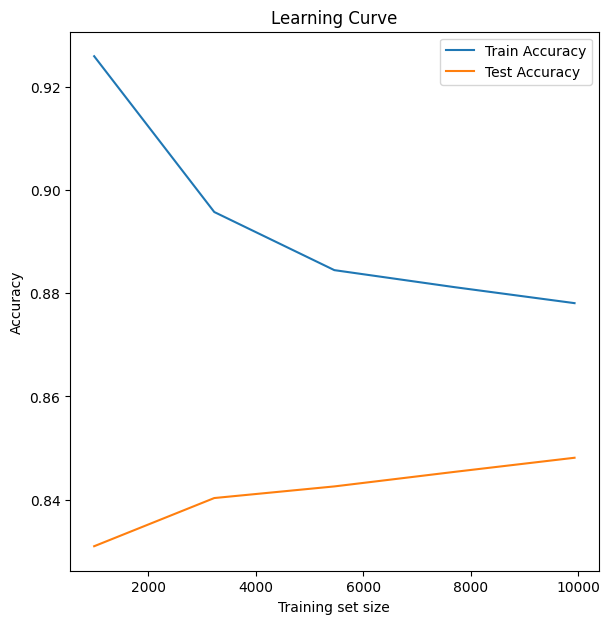

--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8402555910543131 

Train accuracy: 0.9979049153908138
Test accuracy: 0.8402555910543131
Generalization gap: 0.1576493243365007 

Train Time: 58s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.71      0.65      0.68       464
           2       0.82      0.71      0.76       353

    accuracy                           0.84      2191
   macro avg       0.81      0.77      0.78      2191
weighted avg       0.84      0.84      0.84      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> SVC 

Accuracy -->  0.8525787311729803 

Train accuracy: 0.8809024979854956
Test accuracy: 0.8525787311729803
Generalization gap: 0.02832376681251525 

Train Time: 254s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.90      0.92      0.91 

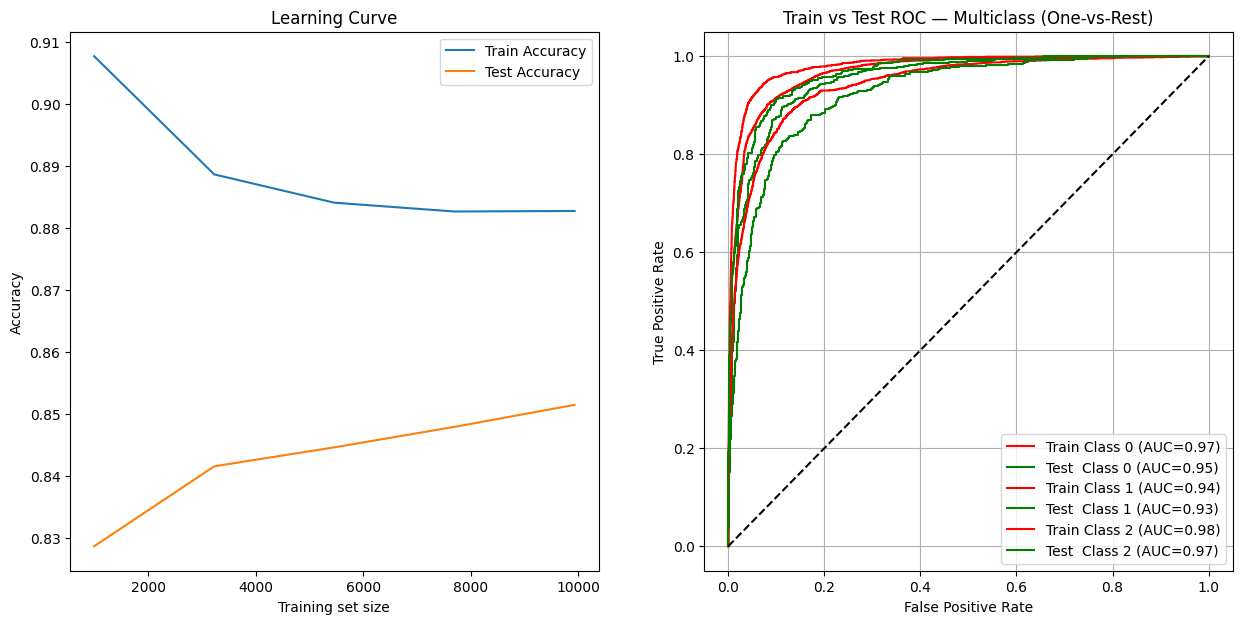

--- Entrainemnt du modèle --------> KNN 

Accuracy -->  0.8028297581013236 

Train accuracy: 0.8678485092667204
Test accuracy: 0.8028297581013236
Generalization gap: 0.0650187511653968 

Train Time: 0s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1374
           1       0.72      0.45      0.56       464
           2       0.73      0.71      0.72       353

    accuracy                           0.80      2191
   macro avg       0.76      0.70      0.72      2191
weighted avg       0.79      0.80      0.79      2191

-----------------------------------------------




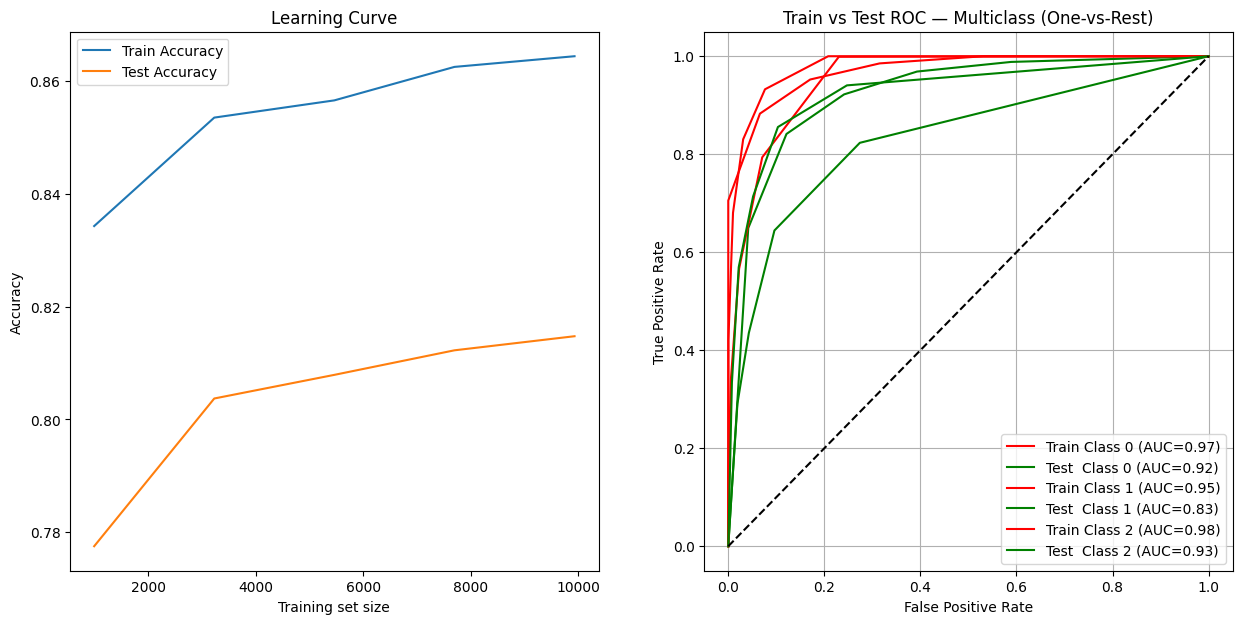

In [36]:
scores_df_clean_1, models_clean_1 = train_multiple_models(*clean_sets)

##### 4.2. Data 2: data_clean (Balanced)

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8265632131446828 

Train accuracy: 0.8432715551974215
Test accuracy: 0.8265632131446828
Generalization gap: 0.016708342052738634 

Train Time: 2s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1374
           1       0.63      0.81      0.71       464
           2       0.76      0.81      0.79       353

    accuracy                           0.83      2191
   macro avg       0.78      0.82      0.79      2191
weighted avg       0.85      0.83      0.83      2191

-----------------------------------------------




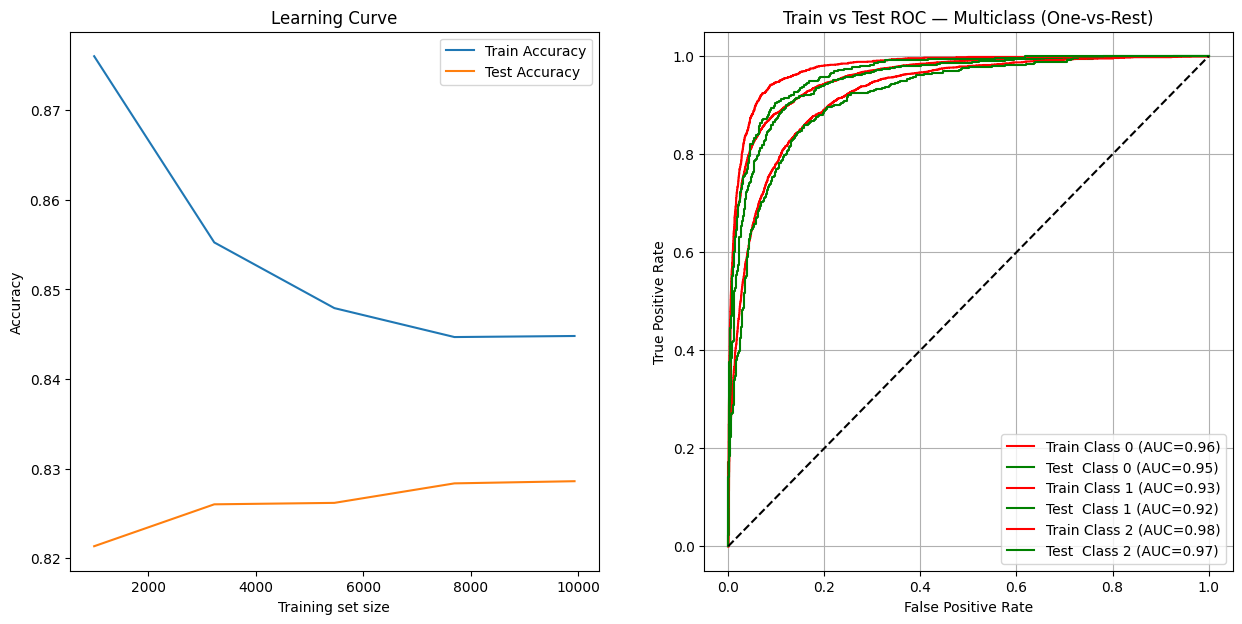

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7526243724326791 

Train accuracy: 0.9979049153908138
Test accuracy: 0.7526243724326791
Generalization gap: 0.24528054295813473 

Train Time: 57s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1374
           1       0.78      0.25      0.38       464
           2       0.88      0.51      0.65       353

    accuracy                           0.75      2191
   macro avg       0.80      0.58      0.62      2191
weighted avg       0.77      0.75      0.71      2191

-----------------------------------------------




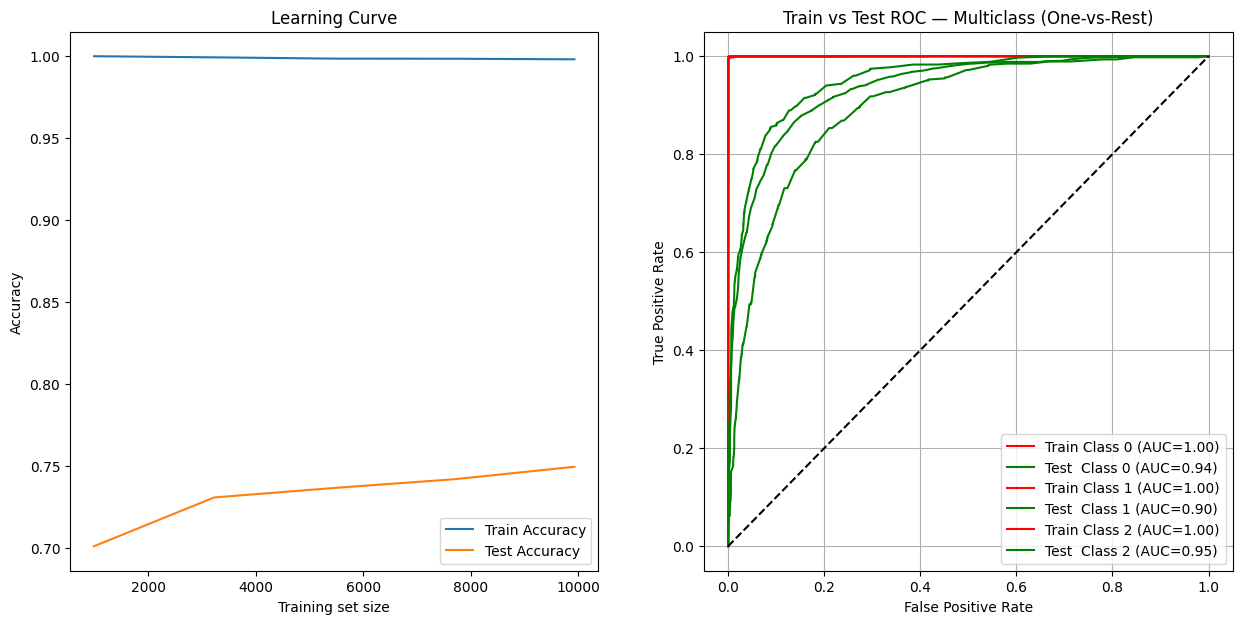

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8457325422181652 

Train accuracy: 0.8712328767123287
Test accuracy: 0.8457325422181652
Generalization gap: 0.025500334494163557 

Train Time: 5s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1374
           1       0.69      0.78      0.73       464
           2       0.77      0.79      0.78       353

    accuracy                           0.85      2191
   macro avg       0.80      0.82      0.81      2191
weighted avg       0.85      0.85      0.85      2191

-----------------------------------------------




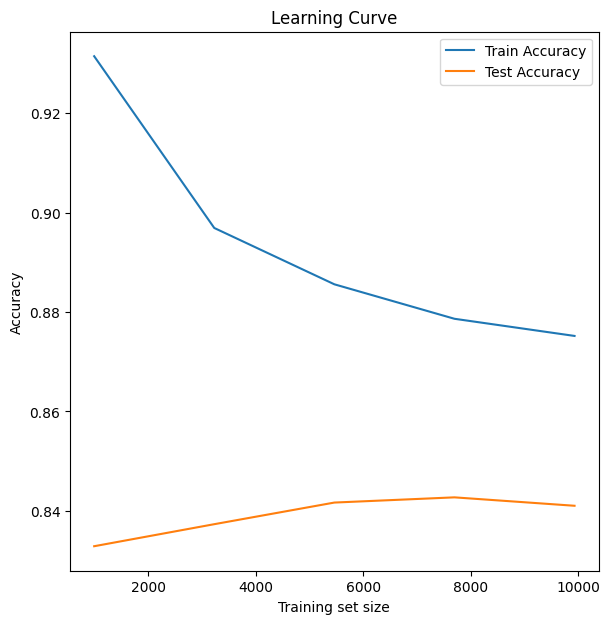

--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8402555910543131 

Train accuracy: 0.9979049153908138
Test accuracy: 0.8402555910543131
Generalization gap: 0.1576493243365007 

Train Time: 60s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.71      0.65      0.68       464
           2       0.82      0.71      0.76       353

    accuracy                           0.84      2191
   macro avg       0.81      0.77      0.78      2191
weighted avg       0.84      0.84      0.84      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> SVC 

Accuracy -->  0.8283888635326335 

Train accuracy: 0.8676067687348912
Test accuracy: 0.8283888635326335
Generalization gap: 0.03921790520225765 

Train Time: 321s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89 

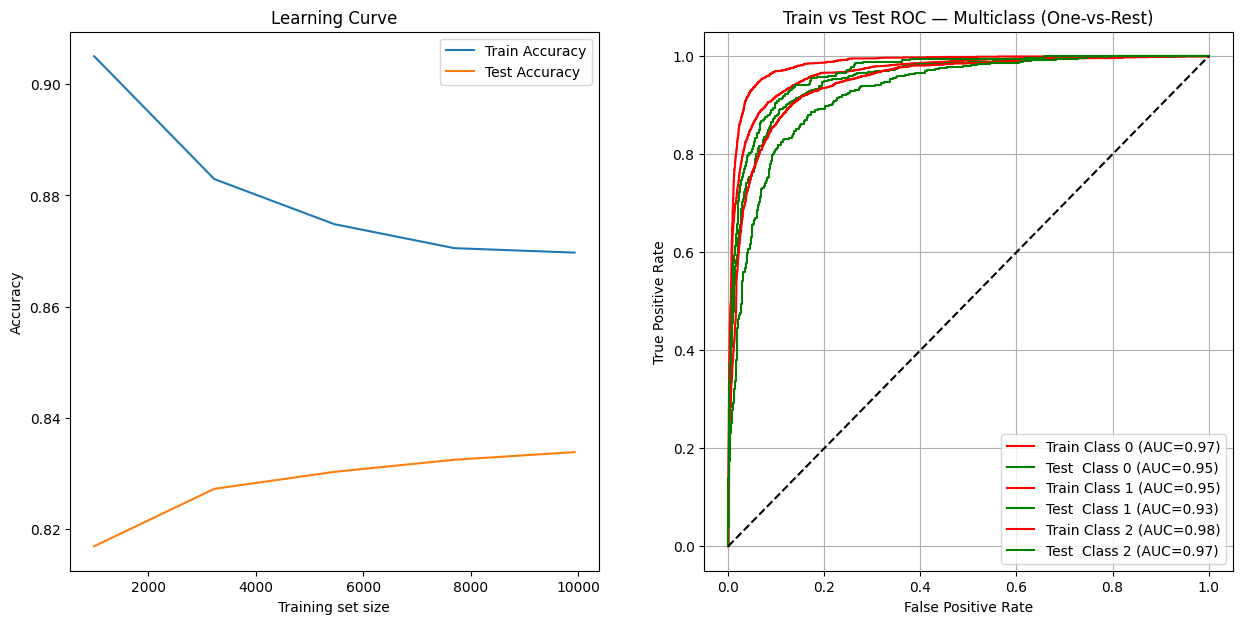

--- Entrainemnt du modèle --------> KNN 

Accuracy -->  0.8028297581013236 

Train accuracy: 0.8678485092667204
Test accuracy: 0.8028297581013236
Generalization gap: 0.0650187511653968 

Train Time: 0s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1374
           1       0.72      0.45      0.56       464
           2       0.73      0.71      0.72       353

    accuracy                           0.80      2191
   macro avg       0.76      0.70      0.72      2191
weighted avg       0.79      0.80      0.79      2191

-----------------------------------------------




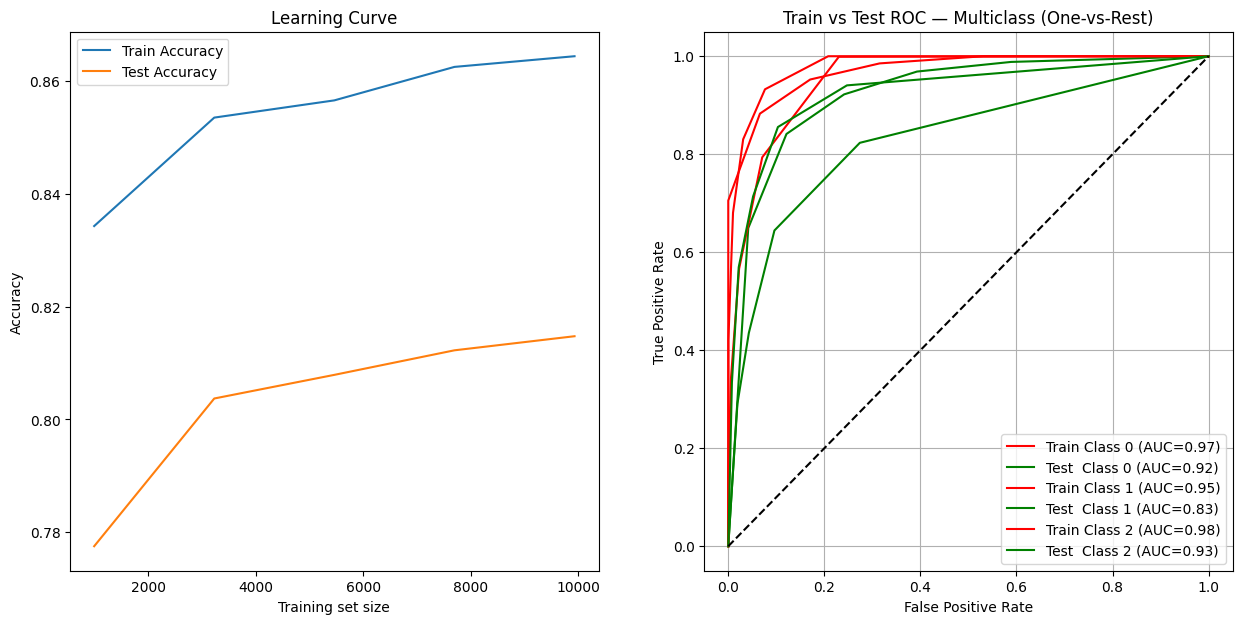

In [37]:
scores_df_clean_2, models_clean_2 = train_multiple_models(*clean_sets, "balanced")

##### 4.3. Data 3: data_with_mentions

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8233683249657691 

Train accuracy: 0.8431909750201451
Test accuracy: 0.8233683249657691
Generalization gap: 0.019822650054376 

Train Time: 1s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1374
           1       0.63      0.81      0.71       464
           2       0.73      0.80      0.76       353

    accuracy                           0.82      2191
   macro avg       0.77      0.81      0.79      2191
weighted avg       0.85      0.82      0.83      2191

-----------------------------------------------




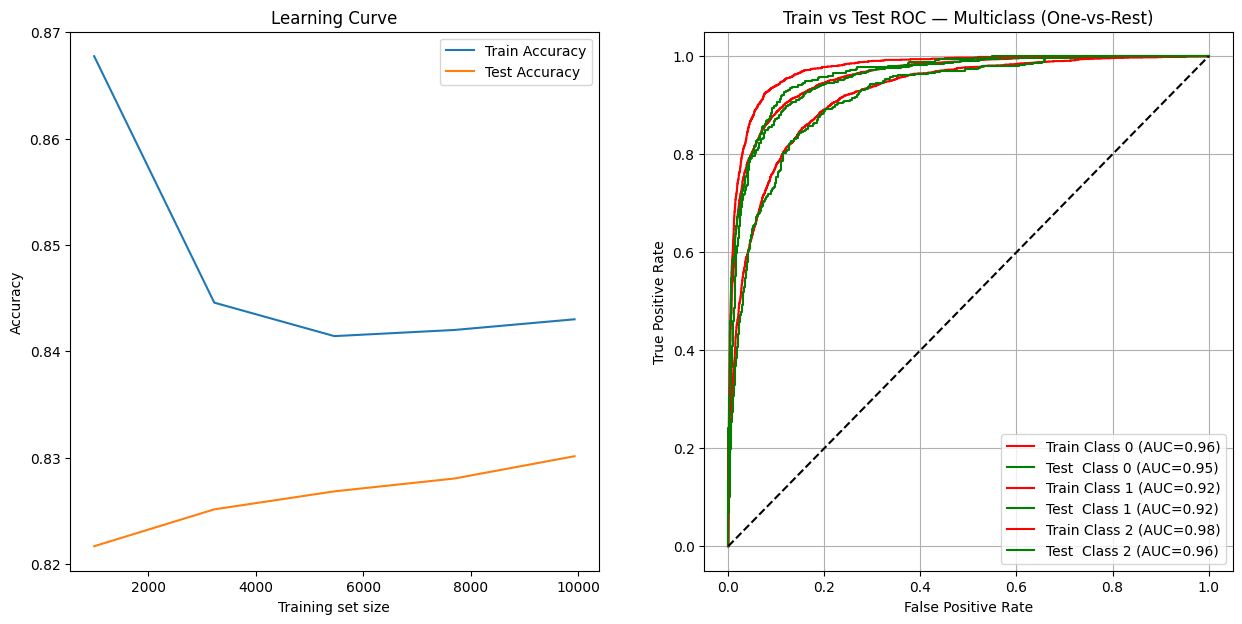

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7759014148790506 

Train accuracy: 0.9980660757453667
Test accuracy: 0.7759014148790506
Generalization gap: 0.22216466086631603 

Train Time: 61s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1374
           1       0.76      0.33      0.46       464
           2       0.87      0.54      0.67       353

    accuracy                           0.78      2191
   macro avg       0.80      0.62      0.66      2191
weighted avg       0.78      0.78      0.75      2191

-----------------------------------------------




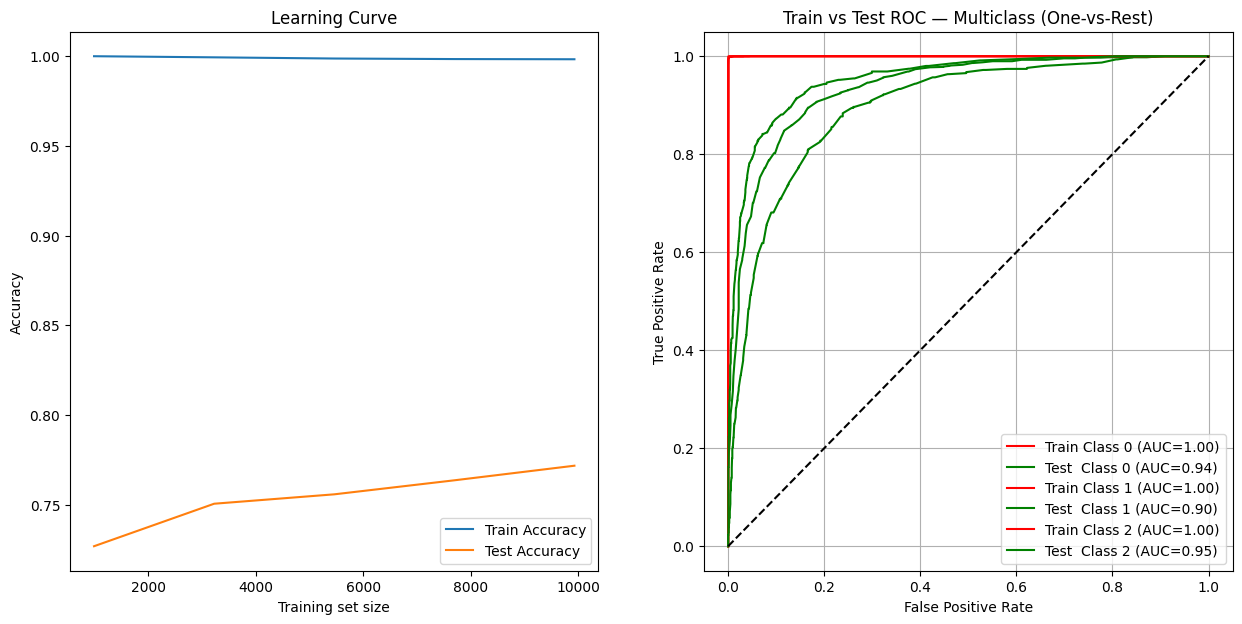

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8407120036513007 

Train accuracy: 0.8705882352941177
Test accuracy: 0.8407120036513007
Generalization gap: 0.02987623164281694 

Train Time: 10s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1374
           1       0.67      0.76      0.72       464
           2       0.76      0.76      0.76       353

    accuracy                           0.84      2191
   macro avg       0.79      0.80      0.80      2191
weighted avg       0.85      0.84      0.84      2191

-----------------------------------------------




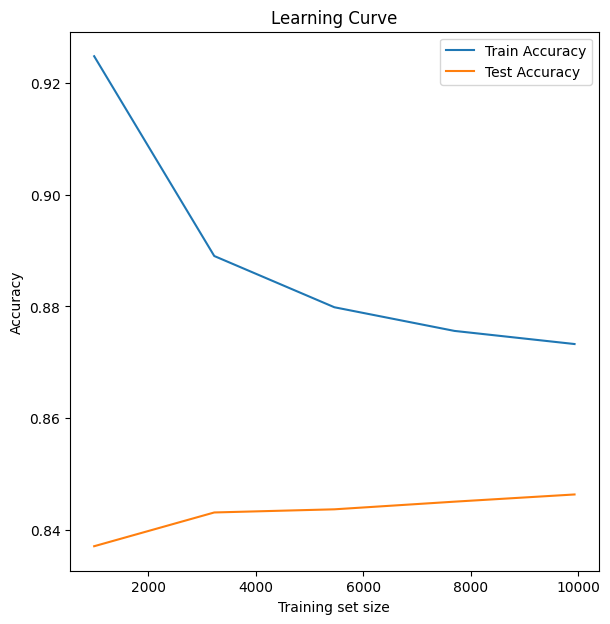

--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.8370607028753994 

Train accuracy: 0.9980660757453667
Test accuracy: 0.8370607028753994
Generalization gap: 0.1610053728699673 

Train Time: 62s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1374
           1       0.71      0.65      0.68       464
           2       0.80      0.69      0.74       353

    accuracy                           0.84      2191
   macro avg       0.80      0.76      0.78      2191
weighted avg       0.83      0.84      0.83      2191

-----------------------------------------------


--- Entrainemnt du modèle --------> SVC 

Accuracy -->  0.8251939753537197 

Train accuracy: 0.8636583400483481
Test accuracy: 0.8251939753537197
Generalization gap: 0.03846436469462833 

Train Time: 607s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89 

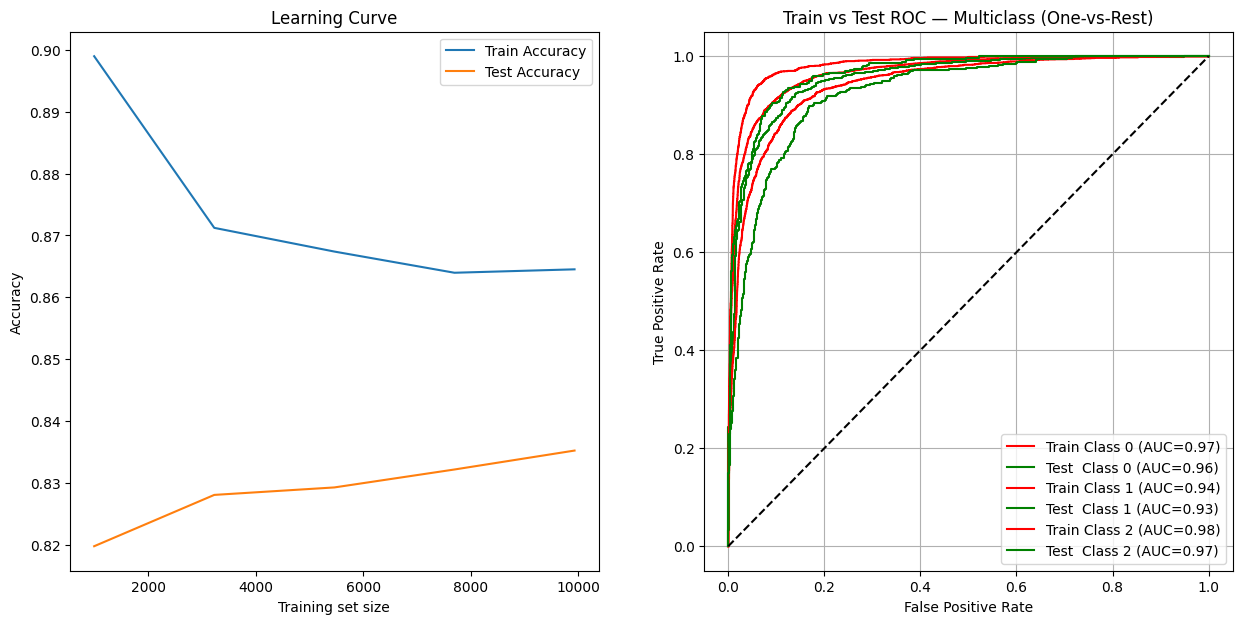

--- Entrainemnt du modèle --------> KNN 

Accuracy -->  0.8069374714742127 

Train accuracy: 0.8602739726027397
Test accuracy: 0.8069374714742127
Generalization gap: 0.05333650112852706 

Train Time: 0s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1374
           1       0.73      0.52      0.61       464
           2       0.64      0.78      0.70       353

    accuracy                           0.81      2191
   macro avg       0.75      0.74      0.73      2191
weighted avg       0.81      0.81      0.80      2191

-----------------------------------------------




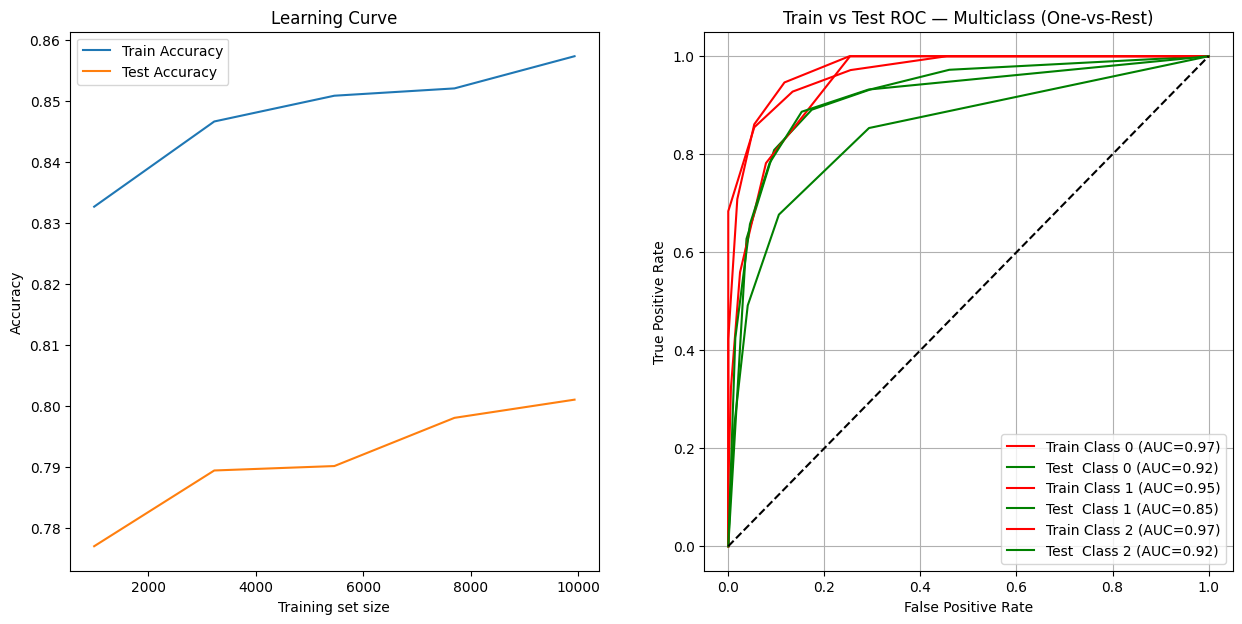

In [38]:
scores_df_mentions, models_mentions = train_multiple_models(*mentions_sets, "balanced")

##### 4.4. Data 4: data_balanced_undersampling

--- Entrainemnt du modèle --------> Logistic Regression 

Accuracy -->  0.8134270101483216 

Train accuracy: 0.830300523848911
Test accuracy: 0.8134270101483216
Generalization gap: 0.016873513700589315 

Train Time: 1s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       464
           1       0.77      0.77      0.77       464
           2       0.83      0.81      0.82       353

    accuracy                           0.81      1281
   macro avg       0.81      0.81      0.81      1281
weighted avg       0.81      0.81      0.81      1281

-----------------------------------------------




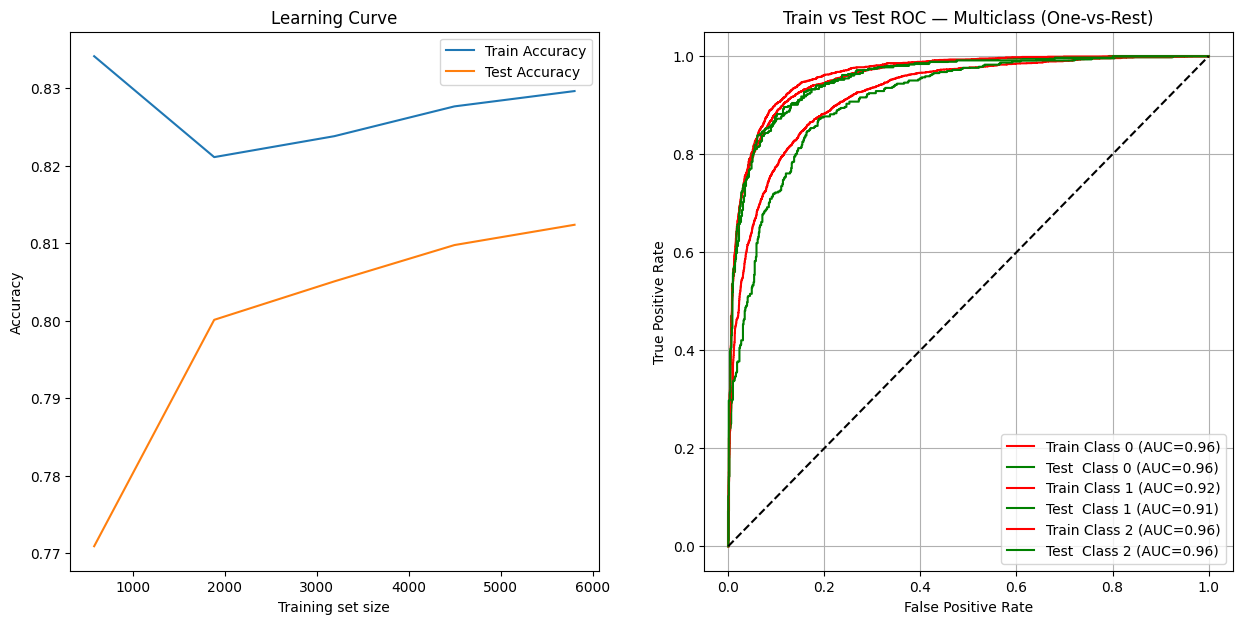

--- Entrainemnt du modèle --------> Random Forest 

Accuracy -->  0.7915690866510539 

Train accuracy: 0.9982078853046595
Test accuracy: 0.7915690866510539
Generalization gap: 0.20663879865360568 

Train Time: 58s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       464
           1       0.74      0.76      0.75       464
           2       0.84      0.76      0.80       353

    accuracy                           0.79      1281
   macro avg       0.80      0.79      0.79      1281
weighted avg       0.79      0.79      0.79      1281

-----------------------------------------------




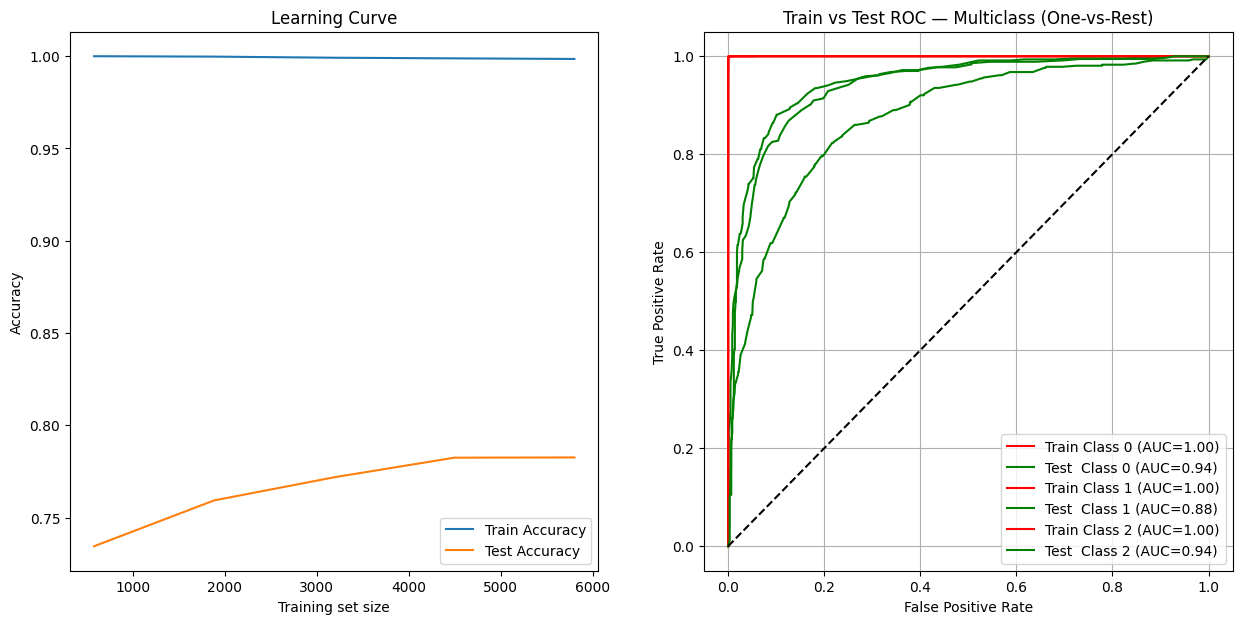

--- Entrainemnt du modèle --------> Linear SVC 

Accuracy -->  0.8095238095238095 

Train accuracy: 0.8508409153570444
Test accuracy: 0.8095238095238095
Generalization gap: 0.04131710583323489 

Train Time: 7s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       464
           1       0.78      0.76      0.77       464
           2       0.81      0.82      0.82       353

    accuracy                           0.81      1281
   macro avg       0.81      0.81      0.81      1281
weighted avg       0.81      0.81      0.81      1281

-----------------------------------------------




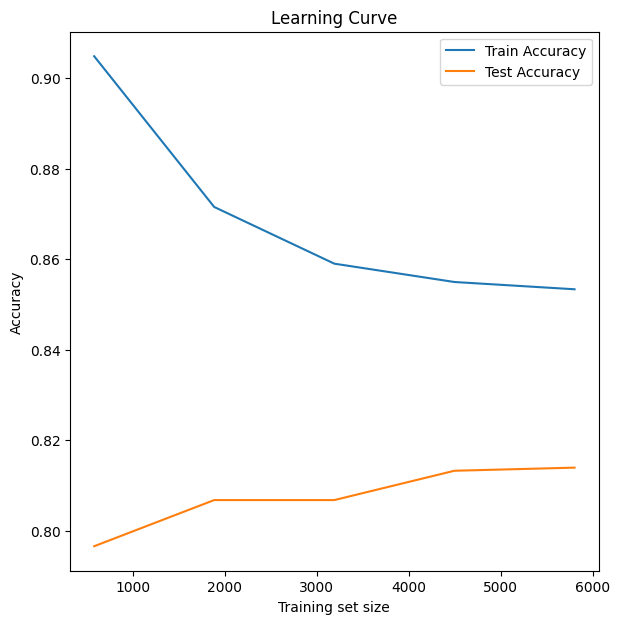

--- Entrainemnt du modèle --------> XGBoost 

Accuracy -->  0.790007806401249 

Train accuracy: 0.9982078853046595
Test accuracy: 0.790007806401249
Generalization gap: 0.20820007890341052 

Train Time: 37s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       464
           1       0.75      0.74      0.74       464
           2       0.79      0.78      0.78       353

    accuracy                           0.79      1281
   macro avg       0.79      0.79      0.79      1281
weighted avg       0.79      0.79      0.79      1281

-----------------------------------------------


--- Entrainemnt du modèle --------> SVC 

Accuracy -->  0.8157689305230289 

Train accuracy: 0.8531844499586435
Test accuracy: 0.8157689305230289
Generalization gap: 0.03741551943561461 

Train Time: 174s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85  

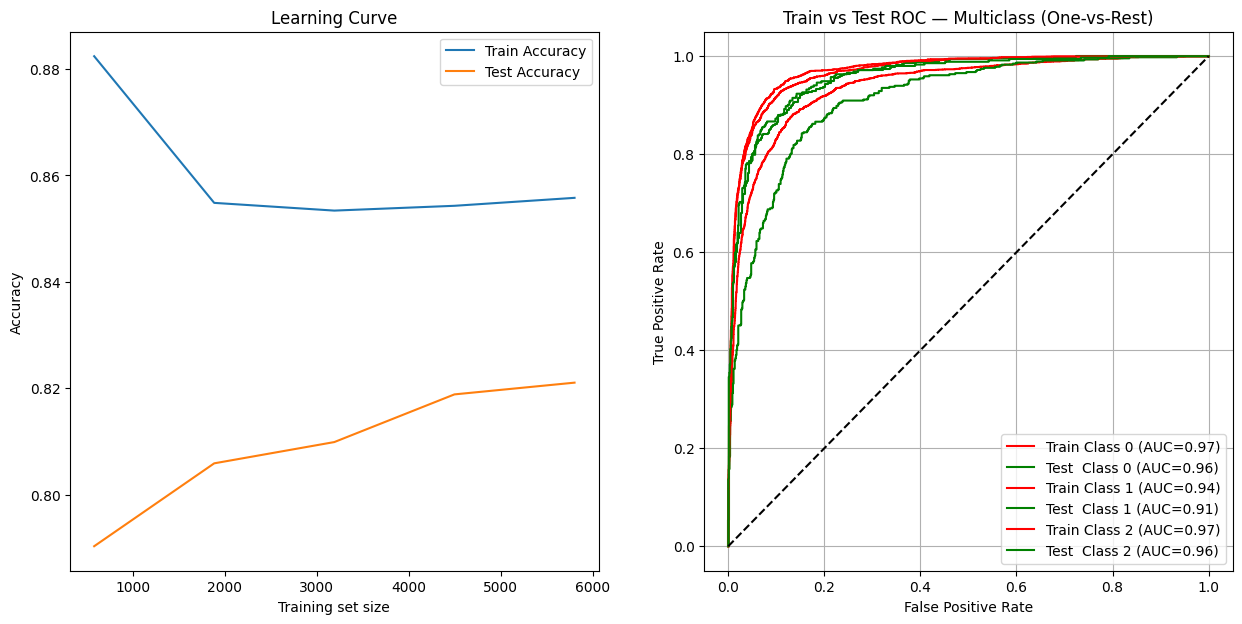

--- Entrainemnt du modèle --------> KNN 

Accuracy -->  0.7252146760343482 

Train accuracy: 0.8203749655362559
Test accuracy: 0.7252146760343482
Generalization gap: 0.09516028950190769 

Train Time: 0s

Rapport de classification:

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       464
           1       0.79      0.53      0.63       464
           2       0.63      0.84      0.72       353

    accuracy                           0.73      1281
   macro avg       0.73      0.73      0.72      1281
weighted avg       0.74      0.73      0.72      1281

-----------------------------------------------




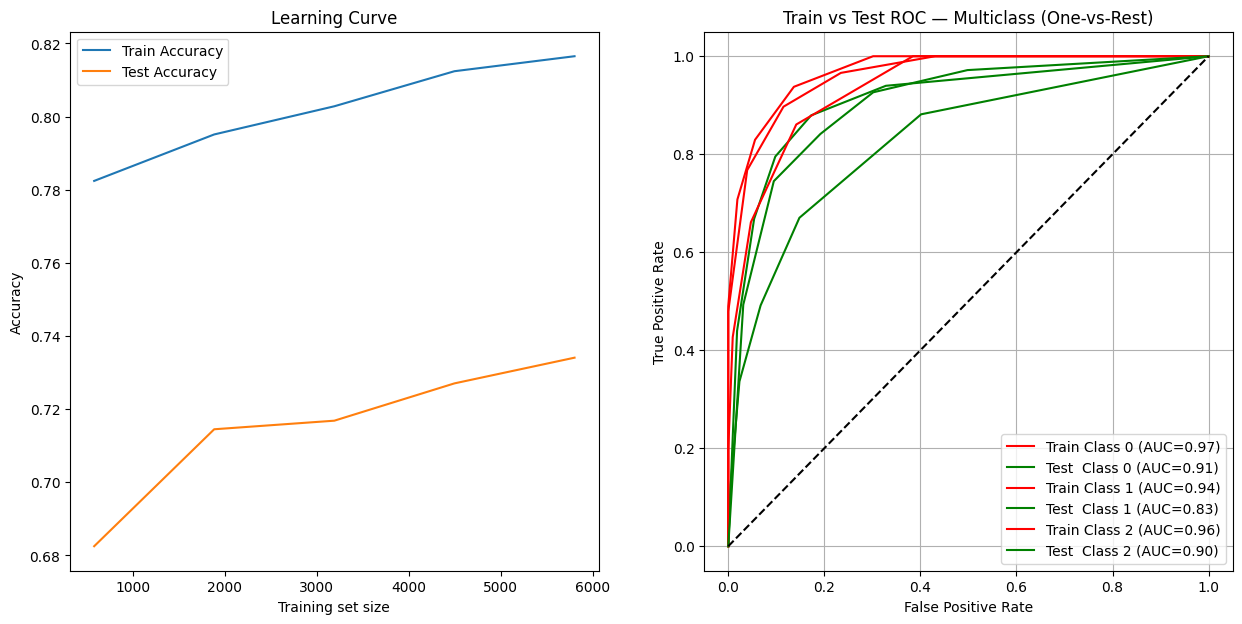

In [39]:
scores_df_undersampling, models_undersampling = train_multiple_models(*undersampling_sets, None, "macro")

##### 5. Comparer les modèles

- Data 1: data_clean

In [40]:
scores_df_clean_1

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap,Train Time (s)
0,Logistic Regression,0.851209,0.848592,0.851209,0.848858,0.011804,3
1,Random Forest,0.785030,0.784374,0.785030,0.761605,0.212875,88
2,Linear SVC,0.848927,0.846506,0.848927,0.847279,0.025932,7
3,XGBoost,0.840256,0.835977,0.840256,0.836630,0.157649,58
4,SVC,0.852579,0.851718,0.852579,0.851637,0.028324,254
5,KNN,0.802830,0.793162,0.802830,0.789845,0.065019,0


- Data 2: data_clean (Balanced)

In [41]:
scores_df_clean_2

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap,Train Time (s)
0,Logistic Regression,0.826563,0.848382,0.826563,0.832670,0.016708,2
1,Random Forest,0.752624,0.768222,0.752624,0.712578,0.245281,57
2,Linear SVC,0.845733,0.852973,0.845733,0.848383,0.025500,5
3,XGBoost,0.840256,0.835977,0.840256,0.836630,0.157649,60
4,SVC,0.828389,0.850053,0.828389,0.834349,0.039218,321
5,KNN,0.802830,0.793162,0.802830,0.789845,0.065019,0


- Data 3: data_with_mentions

In [42]:
scores_df_mentions

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap,Train Time (s)
0,Logistic Regression,0.823368,0.847204,0.823368,0.830023,0.019823,1
1,Random Forest,0.775901,0.781352,0.775901,0.745684,0.222165,61
2,Linear SVC,0.840712,0.847959,0.840712,0.843442,0.029876,10
3,XGBoost,0.837061,0.832228,0.837061,0.833092,0.161005,62
4,SVC,0.825194,0.847983,0.825194,0.831715,0.038464,607
5,KNN,0.806937,0.807059,0.806937,0.801657,0.053337,0


- Data 4: data_balanced_undersampling

In [43]:
scores_df_undersampling

,Name,Accuracy,Precision,Recall,F1,Train_Test Gap,Train Time (s)
0,Logistic Regression,0.813427,0.814346,0.813395,0.813829,0.016874,1
1,Random Forest,0.791569,0.796762,0.788763,0.791842,0.206639,58
2,Linear SVC,0.809524,0.808824,0.810707,0.809647,0.041317,7
3,XGBoost,0.790008,0.789455,0.789133,0.789260,0.208200,37
4,SVC,0.815769,0.818179,0.815777,0.816890,0.037416,174
5,KNN,0.725215,0.731864,0.734476,0.718730,0.095160,0


Random Forest et XGBoost présentent des signes d’overfitting ; ils sont donc écartés. Parmi les modèles restants, la régression logistique offre le meilleur équilibre entre une accuracy élevée, un F1-score acceptable et un écart très faible entre l’accuracy d’entraînement et celle de test (train_acc ≈ test_acc), indiquant l’absence de surapprentissage.

Parmi les modèles de régression logistique entraînés, on peut choisir le premier modèle entraîné sur le jeu de données Data 1.

##### 6. Sauvegarder le meilleur modèle pour la prédiction

In [ ]:
import joblib as jb

jb.dump(models_clean_1['Logistic Regression'], '../models/ml/logistic_regression_1.pkl')

print("Le modèle a été enregistré !")

Le modèle a été enregistré !


##### 7. Optimiser le modèle

- Appliquer grid search

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(random_state=42)

param_grid = {
    'C': [2, 3, 4, 5],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [50, 100, 200]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(clean_sets[0], clean_sets[1])

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 3, 'max_iter': 50, 'solver': 'saga'}
Best CV score: 0.8004116552256525


- Re-entrainer le modéle avec les mielleurs paramètres

In [111]:
log_reg = LogisticRegression(
    random_state=42,
    C=3,
    solver="saga",
    max_iter=50
)

log_reg.fit(clean_sets[0], clean_sets[1])

train_pred = log_reg.predict(clean_sets[0])
test_pred = log_reg.predict(clean_sets[2])

train_acc = accuracy_score(clean_sets[1], train_pred)
test_acc = accuracy_score(clean_sets[3], test_pred)

print(train_acc)
print(test_acc)
print(train_acc - test_acc)

0.8709105560032232
0.851665905979005
0.019244650024218157


- Sauvegarder le modèle

In [ ]:
import joblib as jb

jb.dump(log_reg, '../models/ml/logistic_regression_cv.pkl')

print("Le modèle a été enregistré !")

Le modèle a été enregistré !
